# Import Data

In [1]:
import tensorflow
import keras
import numpy as np
np.random.seed(1248)

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [4]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [5]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID").reset_index(drop=True)

In [6]:
y = labels['bug']
x = x.drop('testcase_ID', axis='columns')

In [9]:
import pickle

with open('../data/x-train-binary','rb') as f:
    x_train = pickle.load(f)
    
with open('../data/y-train-binary','rb') as f:
    y_train = pickle.load(f)
    
with open('../data/x-test-binary','rb') as f:
    x_test = pickle.load(f)
    
with open('../data/y-test-binary','rb') as f:
    y_test = pickle.load(f)

In [10]:
y_train.shape

(17201,)

In [11]:
x_train.shape

(17201, 128)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [12]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [17]:
model = Sequential()

model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_train, y_train, epochs=50, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17201/17201 [==============================] - 1s 70us/step - loss: 0.6763 - acc: 0.5667
Epoch 2/50
17201/17201 [==============================] - 1s 62us/step - loss: 0.6165 - acc: 0.6768
Epoch 3/50
17201/17201 [==============================] - 1s 56us/step - loss: 0.5654 - acc: 0.7199
Epoch 4/50
17201/17201 [==============================] - 1s 49us/step - loss: 0.5118 - acc: 0.7644
Epoch 5/50
17201/17201 [==============================] - 1s 45us/step - loss: 0.4664 - acc: 0.7900
Epoch 6/50
17201/17201 [==============================] - 1s 51us/step - loss: 0.4310 - acc: 0.8087
Epoch 7/50
17201/17201 [==============================] - 1s 48us/step - loss: 0.3920 - acc: 0.8325
Epoch 8/50
17201/17201 [==============================] - 1s 78us/step - loss: 0.3376 - acc: 0.8648
Epoch 9/50
17201/17201 [==============================] - 1s 61us/step - loss: 0.2910 - acc: 0.8871
Epoch 10/50
17201/17201 [===========================

In [20]:
import pickle

In [21]:
with open('../data/baseline-model-binary','wb') as f:
    pickle.dump(model,f)

In [22]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 78us/step


[0.09805650830137205, 0.9486166007905138]

In [23]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [24]:
y_predict= model.predict(x_test)

In [25]:
import numpy as np

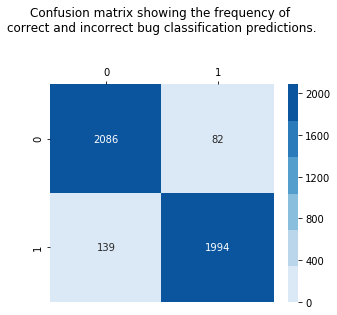

In [26]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

confusion_figure.savefig('../images/baseline_conf_matrix')

In [27]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict)

In [28]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

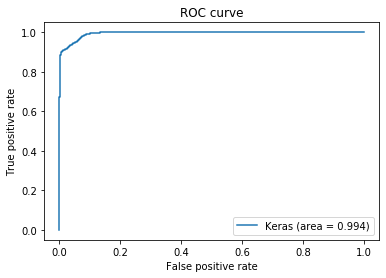

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')